# DeepSurv

In this notebook we will train the [Cox-PH method](http://jmlr.org/papers/volume20/18-424/18-424.pdf), also known as [DeepSurv](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1).

In [1]:
!pip install torchtuples
!pip install pycox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 651.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 388.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.2/411.2 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 39.4 MB/s eta 0:00:00
  Created wheel for feather-format: filename=feather_format-0.4.1-py3-none-any.whl size=2436 sha256=a2218f0203d7cb3a0ebc0f5787607906a87a021876cc3f3fc5a60ac71e3ebd4d
  Stored in directory: /root/.cache/pip/wheels/a6/ff/5d/4f10de26fe5d

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

from sklearn.model_selection import ParameterSampler

In [3]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## 1. Dataset

In [4]:
#pip install scikit-survival

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
# Read the preprocessed file
brca = pd.read_csv('/content/drive/My Drive/3799/brca (stage i-iii).csv')

In [47]:
brca = brca[brca['time'] > 0]

In [48]:
brca.iloc[:,1] = brca.iloc[:,1].astype('float32')

<ipython-input-48-544633b84790>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  brca.iloc[:,1] = brca.iloc[:,1].astype('float32')


## 3. Modelling

### Train, valid, and test set split

In [49]:
df_train = brca
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)

df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [50]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into train, validation, and test sets while maintaining class balance
train_val_data, test_data = train_test_split(brca, test_size=0.2, random_state=42, stratify=brca['status'])

train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=42, stratify=train_val_data['status'])

# Check class distribution in each set
print("Train set class distribution:")
print(train_data['status'].value_counts(normalize=True))

print("\nValidation set class distribution:")
print(val_data['status'].value_counts(normalize=True))

print("\nTest set class distribution:")
print(test_data['status'].value_counts(normalize=True))

Train set class distribution:
0    0.87632
1    0.12368
Name: status, dtype: float64

Validation set class distribution:
0    0.879518
1    0.120482
Name: status, dtype: float64

Test set class distribution:
0    0.879808
1    0.120192
Name: status, dtype: float64


### Feature transforms
We will standardize the numerical covariates, and leave the binary variables as is. As variables needs to be of type `'float32'`, as this is required by pytorch.

# Feature transformation


In [51]:
from sklearn_pandas import DataFrameMapper
# Get a list of all column names in the DataFrame
all_cols = brca.iloc[:,2:].columns.tolist()

# Create a list of tuples for all columns
all_cols_tuples = [(col, None) for col in all_cols]

# Create the DataFrameMapper object with all columns
x_mapper = DataFrameMapper(all_cols_tuples)

In [52]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [53]:
# Extract target
get_target = lambda df: (df['time'].values, df['status'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
y_test=get_target(df_test)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

### Neural net

We create a simple MLP with two hidden layers, ReLU activations, batch norm and dropout.
Here, we just use the `torchtuples.practical.MLPVanilla` net to do this.

Note that we set `out_features` to 1, and that we have not `output_bias`.

In [54]:
from sklearn.base import BaseEstimator

class DeepSURVSklearnAdapter(BaseEstimator):
    def __init__(
        self,
        learning_rate=1e-4,
        batch_norm=True,
        dropout=0.0,
        num_nodes=[32, 32],
        batch_size=128,
        epochs=10,
    ):
        self.learning_rate = learning_rate
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.num_nodes = num_nodes
        self.batch_size = batch_size
        self.epochs = epochs

    def fit(self, X, y):
        self.net_ = tt.practical.MLPVanilla(
            X.shape[1],
            self.num_nodes,
            1,
            self.batch_norm,
            self.dropout,
            output_bias = False, # prevent overfitting/simplify the model
        )
        self.deepsurv_ = CoxPH(self.net_, tt.optim.Adam)
        self.deepsurv_.optimizer.set_lr(self.learning_rate)

        # Sklearn needs the y inputs to be arranged as a matrix with each row
        # corresponding to an example but CoxPH needs a tuple with two arrays?
        y_ = (y[0], y[1])

        callbacks = [tt.callbacks.EarlyStopping()]
        log = self.deepsurv_.fit(
            X,
            y_,
            self.batch_size,
            self.epochs,
            verbose=False,
        )

        return self

    def score(self, X, y):
        _ = self.deepsurv_.compute_baseline_hazards()
        surv = self.deepsurv_.predict_surv_df(X)

        ev = EvalSurv(
            surv,
            y[0],  # time to event
            y[1],  # event
            censor_surv="km",
        )

        return ev.concordance_td()

    def predict(self, X):
      # Predict survival probabilities for X
      return self.deepsurv_.predict_surv_df(X)

In [55]:
# Define the parameter grid for random search
param_grid = {
    'learning_rate': [1e-1, 1e-2, 1e-3, 1e-4],
    'dropout': [0.0, 0.1, 0.2],
    'num_nodes': [[32, 32], [64, 64], [32, 64]],
    'batch_size': [128, 256, 512],
    'epochs': [512]
}

# Define the number of parameter settings that will be sampled
n_iter = 10

# Perform random search
random_search = ParameterSampler(param_grid, n_iter=n_iter, random_state=123)

best_score = float('-inf')
best_params = None

for params in random_search:
    print("Current parameters:", params)
    model = DeepSURVSklearnAdapter(**params)
    model.fit(x_train, y_train)
    c_index = model.score(x_val, y_val)
    print("C-index:", round(c_index,3))
    if c_index > best_score:
        best_score = c_index
        best_params = params
    print("=" * 40)

print("Best parameters:", best_params)
print("Best C-index:", best_score)

Current parameters: {'num_nodes': [32, 32], 'learning_rate': 0.1, 'epochs': 512, 'dropout': 0.1, 'batch_size': 512}


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


C-index: 0.703
Current parameters: {'num_nodes': [64, 64], 'learning_rate': 0.01, 'epochs': 512, 'dropout': 0.2, 'batch_size': 512}


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


C-index: 0.743
Current parameters: {'num_nodes': [32, 32], 'learning_rate': 0.01, 'epochs': 512, 'dropout': 0.1, 'batch_size': 512}


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


C-index: 0.727
Current parameters: {'num_nodes': [32, 32], 'learning_rate': 0.001, 'epochs': 512, 'dropout': 0.0, 'batch_size': 256}


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


C-index: 0.752
Current parameters: {'num_nodes': [32, 64], 'learning_rate': 0.1, 'epochs': 512, 'dropout': 0.2, 'batch_size': 256}


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


C-index: 0.719
Current parameters: {'num_nodes': [64, 64], 'learning_rate': 0.001, 'epochs': 512, 'dropout': 0.2, 'batch_size': 128}


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


C-index: 0.0
Current parameters: {'num_nodes': [64, 64], 'learning_rate': 0.1, 'epochs': 512, 'dropout': 0.1, 'batch_size': 128}


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


C-index: 0.0
Current parameters: {'num_nodes': [32, 64], 'learning_rate': 0.001, 'epochs': 512, 'dropout': 0.1, 'batch_size': 256}


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


C-index: 0.714
Current parameters: {'num_nodes': [32, 64], 'learning_rate': 0.1, 'epochs': 512, 'dropout': 0.0, 'batch_size': 256}


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


C-index: 0.754
Current parameters: {'num_nodes': [32, 64], 'learning_rate': 0.001, 'epochs': 512, 'dropout': 0.0, 'batch_size': 128}
C-index: 0.0
Best parameters: {'num_nodes': [32, 64], 'learning_rate': 0.1, 'epochs': 512, 'dropout': 0.0, 'batch_size': 256}
Best C-index: 0.7541463414634146


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


## Prediction

In [56]:
# Create and train the best model with the best parameters
best_model = DeepSURVSklearnAdapter(**best_params)
best_model.fit(x_train, y_train)

DeepSURVSklearnAdapter(batch_size=256, epochs=512, learning_rate=0.1,
                       num_nodes=[32, 64])

In [57]:
train_c_index = best_model.score(x_train, y_train)
print("C-index on train data:", round(train_c_index,3))

C-index on train data: 0.994


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


In [58]:
# Evaluate the best model on the test data
test_c_index = best_model.score(x_test, y_test)
print("C-index on test data:", round(test_c_index,3))

C-index on test data: 0.632


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


In [59]:
# Make predictions using the best model
predictions = best_model.predict(x_test)

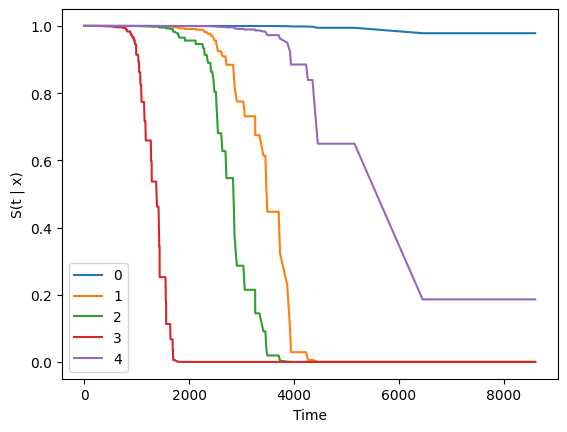

In [60]:
# prediction: predicted survival probability
predictions.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [61]:
# Calculate the hazard function
hazard_function = -np.log(predictions).diff(axis=1)

# The first column of the hazard function contain NaN value
# replace them with 0
hazard_function[hazard_function.columns[0]] = 0

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


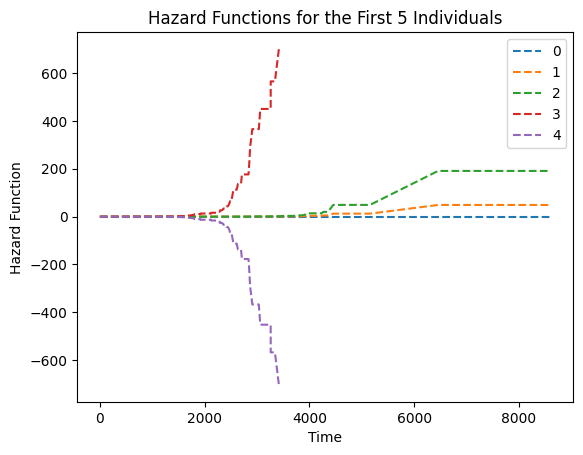

In [62]:
# Plot hazard function
hazard_function.iloc[:, :5].plot(style='--', title='Hazard Functions for the First 5 Individuals')
plt.ylabel('Hazard Function')
plt.xlabel('Time')
plt.show()